In [1]:
!nvidia-smi

Tue Oct  6 22:34:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 29%   24C    P8     1W / 250W |    164MiB / 11016MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1C:00.0 Off |                  N/A |
| 29%   23C    P8    10W / 250W |   1080MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import numpy as np
from functools import partial
import tensorflow as tf
import scipy

from scipy.io import loadmat
from keras.layers import Input

from vdae.networks import VDAE, SpectralNet
from vdae.vdae_util import *

%matplotlib inline

Using TensorFlow backend.


# DATASET

In [11]:
dataset = 'mnist'

if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
    bsize = 512
elif dataset == 'coil20hr':
    d_in = scipy.io.loadmat('data/COIL20_UNPROC_128.mat')
    X = d_in['X'] / np.max(d_in['X'])
    Y = d_in['Y']-1
    Y = Y.reshape(-1)
    x_train, x_test = X.reshape((len(X), -1)), X.reshape((len(X), -1))
    y_train, y_test = Y, Y
    latent_dim = 10
    bsize = 256
elif dataset == 'bulldog':
    (x_train, y_train), (x_test, y_test) = generate_bulldog()
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 5
    bsize = len(x_train)

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset and 'cifar' not in dataset and 'bulldog' not in dataset and 'gaussian_grid' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b

arch = [
    {'type': 'relu', 'size': 500},
    {'type': 'linear', 'size': latent_dim},
    ]

11493376/11490434 [==============================] - 0s 0us/step


# TRAIN SPECTRALNET

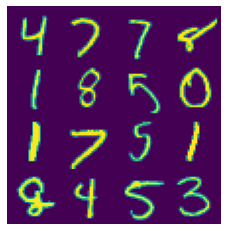

In [12]:
g = plot(x_train, y_train)

In [13]:
n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }

In [15]:
spectral_net = SpectralNet(inputs=inputs, arch=arch,
                spec_reg=None, y_true=y_true, y_train_labeled_onehot=y_train_labeled_onehot,
                n_clusters=n_clusters, affinity='knn', scale_nbr=2, n_nbrs=2, 
                batch_sizes=batch_sizes, siamese_net=None, 
                x_train=x_train, have_labeled=False)

IMPORTANT: [<tf.Variable 'Unlabeled_3/spectral_0/kernel:0' shape=(784, 500) dtype=float32>, <tf.Variable 'Unlabeled_3/spectral_0/bias:0' shape=(500,) dtype=float32>, <tf.Variable 'Unlabeled_4/spectral_1/kernel:0' shape=(500, 10) dtype=float32>, <tf.Variable 'Unlabeled_4/spectral_1/bias:0' shape=(10,) dtype=float32>] <tf.Variable 'ortho_weights_store:0' shape=(10, 10) dtype=float32_ref>


In [16]:
spectral_net.train(
            x_train, np.zeros_like(x_train[0:0]), x_test,
            lr=1e-5, drop=0.1, patience=20, num_epochs=200)

Epoch: 0, val_loss=2.030742
Epoch: 0, loss=232.951432, val_loss=42.306969
Epoch: 1, loss=204.608001, val_loss=31.912931
Epoch: 2, loss=156.857409, val_loss=25.901018
Epoch: 3, loss=129.993177, val_loss=21.074869
Epoch: 4, loss=111.641395, val_loss=18.609787
Epoch: 5, loss=99.668757, val_loss=16.871122
Epoch: 6, loss=90.341618, val_loss=15.030890
Epoch: 7, loss=84.352667, val_loss=13.556819
Epoch: 8, loss=78.565328, val_loss=12.920952
Epoch: 9, loss=74.601422, val_loss=12.442952
Epoch: 10, loss=72.226726, val_loss=12.683383
Epoch: 11, loss=69.379200, val_loss=12.321092
Epoch: 12, loss=66.501443, val_loss=11.563234
Epoch: 13, loss=65.160081, val_loss=11.387858
Epoch: 14, loss=63.272766, val_loss=11.311862
Epoch: 15, loss=61.877543, val_loss=10.928144
Epoch: 16, loss=60.176234, val_loss=10.382078
Epoch: 17, loss=59.364709, val_loss=10.141935
Epoch: 18, loss=58.663512, val_loss=10.242252
Epoch: 19, loss=57.280232, val_loss=9.721633
Epoch: 20, loss=56.615054, val_loss=9.869175
Epoch: 21, lo

Epoch: 180, loss=39.045248, val_loss=6.595244
Epoch: 181, loss=39.446134, val_loss=6.651637
Epoch: 182, loss=38.615807, val_loss=6.845189
Epoch: 183, loss=38.735570, val_loss=6.519260
Epoch: 184, loss=39.177300, val_loss=6.775485
Epoch: 185, loss=39.155842, val_loss=6.342036
Epoch: 186, loss=38.959234, val_loss=6.368039
Epoch: 187, loss=38.963816, val_loss=7.119587
Epoch: 188, loss=38.780422, val_loss=6.568085
Epoch: 189, loss=39.166420, val_loss=6.822372
Epoch: 190, loss=38.462995, val_loss=6.815816
Epoch: 191, loss=39.016329, val_loss=6.552666
Epoch: 192, loss=38.464677, val_loss=6.403755
Epoch: 193, loss=38.839475, val_loss=6.502552
STOPPING EARLY


(array([232.95143175, 204.60800135, 156.85740864, 129.9931767 ,
        111.64139467,  99.66875738,  90.34161842,  84.3526668 ,
         78.56532824,  74.60142183,  72.22672623,  69.37919956,
         66.50144291,  65.16008145,  63.27276552,  61.87754339,
         60.17623419,  59.3647089 ,  58.66351208,  57.28023183,
         56.61505446,  55.64614198,  54.75715879,  53.47158128,
         53.25575641,  52.59147924,  51.58722964,  51.39951757,
         51.32235631,  50.70804349,  49.8121801 ,  50.12379718,
         49.74138427,  48.71304008,  48.58236304,  48.72931039,
         47.82307521,  48.13472134,  48.20638394,  47.14914563,
         46.6377129 ,  46.67195001,  45.80493724,  46.23314402,
         46.11563414,  45.59123948,  45.77913979,  45.27400056,
         45.19473669,  44.78923911,  44.74817622,  44.58298442,
         44.35812801,  44.07332176,  44.31264082,  43.92972791,
         43.65466872,  43.6133855 ,  43.52218342,  43.09078297,
         43.55570865,  42.9147259 ,  42.

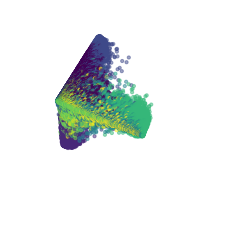

In [17]:
y_pred = spectral_net.predict(x_train)
g = plot(y_pred[:,:3], y_train.reshape(-1,))

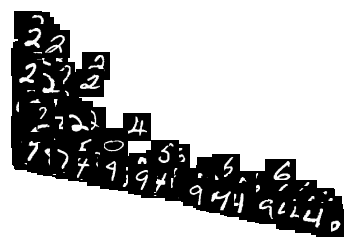

In [19]:
# plot images over embeddings
if 'mnist' in dataset or 'cifar' in dataset or 'coil' in dataset or 'faces' in dataset:
    p = np.random.permutation(len(x_train))[:512]
    zoom = 1
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    elif 'coil' in dataset and 'hr' in dataset:
        img_shape = (128, 128)
        zoom = 0.2
    elif 'coil' in dataset:
        img_shape = (32, 32)
    elif 'faces' in dataset:
        img_shape = (28, 20)
        zoom = 2
    _ = imscatter(y_pred[p,0], y_pred[p,1], x_train[p], shape=img_shape, zoom=zoom)

# TRAIN VDAE

In [20]:
svg_bsize = 288
svg_k = 2
svg_arch = [500]

svg = VDAE(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[1:], k=svg_k, alpha=1., arch=svg_arch)

IMPORTANT (?, 2)
z_mu_nb (?, 2, 10)

IMPORTANT (?, 2)
important input shape (?, 784)
NEIGHBORHOOD AND RECON SHAPES: (?, 784) (?, 784)


In [ ]:
svg.train(x_train, epochs=10000, batch_size=svg_bsize, full_batch=True)



0 [VAE loss: 3344661.0] [kl_loss: 2823763.25] [neighborhood_loss: 8036.8017578125]
vector covariance:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.7963318  0.68991977 0.85102326 0.81615907 0.78607684 0.7626209
  0.676426   0.6469935  0.99031913 1.4460503 ]]
25 [VAE loss: 291677.0625] [kl_loss: 289143.375] [neighborhood_loss: 3241.092529296875]
vector covariance:
 [[ 0.58597

100 [VAE loss: 228927.0] [kl_loss: 225363.3125] [neighborhood_loss: 2691.78125]
vector covariance:
 [[ 9.95771646e-01 -4.64790530e-04  2.27561053e-02 -9.90020111e-03
  -1.44603020e-02 -5.45217330e-03  1.40202064e-02  4.33181375e-02
  -7.41703957e-02 -3.10617965e-03]
 [-1.57413317e-03  9.96619284e-01  3.36878411e-02 -3.81937474e-02
   7.93342246e-04 -4.80604284e-02 -3.86161357e-02 -1.69535610e-03
  -1.64875202e-02 -8.80348682e-03]
 [-2.17454042e-02 -3.15816253e-02  9.95007336e-01 -1.42715988e-03
   4.30785306e-02 -2.02027056e-02  7.32912496e-02  6.67364802e-03
   2.51187142e-02 -1.33083742e-02]
 [ 8.79236590e-03  3.79379243e-02  4.91428282e-03  9.95196998e-01
  -7.63380826e-02 -1.35573465e-02  1.35277200e-03  3.77012677e-02
   2.45271791e-02  2.42219237e-03]
 [ 1.80083252e-02 -7.64814904e-04 -4.27563898e-02  7.33513758e-02
   9.91238058e-01 -6.49969205e-02 -3.79133448e-02  2.71276105e-02
   4.08695862e-02 -4.29593883e-02]
 [ 1.14363255e-02  4.72610183e-02  2.17592586e-02  1.76950973e-02

175 [VAE loss: 209707.625] [kl_loss: 206337.703125] [neighborhood_loss: 2559.88671875]
vector covariance:
 [[ 4.93418753e-01  9.72870961e-02  4.24971163e-01  2.01005518e-01
  -5.38220048e-01  1.55525982e-01 -3.06672573e-01 -8.65995362e-02
  -3.01074564e-01  1.41445786e-01]
 [ 5.21777384e-03  9.86785531e-01 -4.54399809e-02 -5.07236980e-02
   7.72777349e-02 -2.57324725e-02 -4.20994088e-02 -8.14009365e-03
   1.12039350e-01 -2.37447936e-02]
 [ 3.50110143e-01  3.32878381e-02  3.94058555e-01 -1.14509515e-01
   2.07053244e-01 -1.06296397e-03  6.83724284e-01  3.89025152e-01
  -1.39175551e-02  2.14557722e-01]
 [ 1.44437611e-01  2.74145813e-03 -1.61545277e-01  9.20404315e-01
   1.19883247e-01 -5.18517420e-02  1.01625040e-01  5.91967516e-02
   2.72939026e-01  2.23799311e-02]
 [-4.66892481e-01  7.38469437e-02  2.19018489e-01  2.54616767e-01
   3.73714089e-01  1.12481184e-01 -1.09178513e-01  5.77711426e-02
  -6.24092400e-01  3.26643974e-01]
 [ 3.27160209e-02 -1.60197094e-02 -1.18475044e-02 -2.77146

250 [VAE loss: 201242.671875] [kl_loss: 198527.75] [neighborhood_loss: 2482.6748046875]
vector covariance:
 [[ 9.99668539e-01  1.81966450e-03 -8.29690322e-03 -1.44939069e-02
  -1.09344414e-02  9.04601347e-03  3.72242270e-04  1.16429189e-02
  -2.88641982e-04 -6.58815866e-03]
 [-1.87022716e-03  9.99883175e-01 -7.51481671e-03 -8.53202306e-03
  -1.31520501e-03 -3.90811358e-03 -1.08314061e-03 -5.94718382e-03
   1.01489080e-04  6.88046217e-03]
 [ 7.77558982e-03  7.50059402e-03  9.99398112e-01 -2.25841925e-02
   3.03823547e-03  6.69646962e-03 -9.20261350e-03  2.41893460e-03
   7.37527339e-03 -1.94419511e-02]
 [ 1.44844390e-02  8.73929821e-03  2.18746439e-02  9.99056339e-01
  -1.60461906e-02  6.15520985e-04 -1.68672111e-02 -1.07015474e-02
   1.16679631e-02 -1.81289837e-02]
 [ 1.10731367e-02  1.49209844e-03 -2.84484471e-03  1.59303043e-02
   9.99762595e-01 -3.68294609e-03 -3.74881248e-03  7.37221120e-03
  -7.74920802e-04 -2.37045437e-03]
 [-8.91683437e-03  3.71321244e-03 -6.17489731e-03  1.9702

325 [VAE loss: 197332.609375] [kl_loss: 194708.90625] [neighborhood_loss: 2443.81640625]
vector covariance:
 [[ 9.9969697e-01 -7.6514139e-04  5.3268527e-03 -1.0033448e-02
   5.4662661e-03  3.1812389e-03 -1.4829072e-02 -7.2800447e-03
   1.1663926e-02 -5.2391272e-03]
 [ 7.7834737e-04  9.9994791e-01 -4.2438125e-03 -4.2491867e-03
  -7.4301235e-04 -1.9422965e-03  2.2764758e-05  2.1571370e-03
   2.6463738e-03  7.1725450e-03]
 [-5.1876092e-03  4.2346013e-03  9.9954396e-01  2.9699309e-03
  -2.2659719e-02  3.7321902e-03 -1.0034266e-02  1.4729198e-02
  -3.4794030e-03 -1.1006254e-03]
 [ 1.0051495e-02  4.2766179e-03 -2.8503691e-03  9.9988830e-01
  -1.4184504e-04 -2.4316192e-03  4.8226984e-03 -2.2043646e-03
   2.3059000e-03 -7.5271400e-03]
 [-6.0781436e-03  9.0381625e-04  2.2471968e-02  3.2655234e-04
   9.9937856e-01  1.2009965e-02 -2.1200839e-02 -6.4331377e-03
   6.0393582e-03 -5.3109587e-03]
 [-2.9251049e-03  1.8550018e-03 -4.0457891e-03  2.5150215e-03
  -1.1797511e-02  9.9984962e-01  2.8046698e-

400 [VAE loss: 195486.625] [kl_loss: 193042.828125] [neighborhood_loss: 2410.5166015625]
vector covariance:
 [[ 9.99838412e-01 -2.06305971e-03  3.24273505e-03 -7.58149056e-03
   7.97558296e-03  5.24875941e-03 -6.63345959e-03 -4.67210962e-03
   3.47067835e-03 -9.03968420e-03]
 [ 2.08187173e-03  9.99963939e-01 -2.36747484e-03 -4.84958378e-04
   3.96291632e-03 -5.90184610e-03  6.49532478e-04 -1.14235957e-03
   1.84496678e-03  2.50168471e-03]
 [-3.13960412e-03  2.46496522e-03  9.99691665e-01 -7.64085492e-03
  -2.05917358e-02  1.66509917e-03 -6.39646454e-03  7.98616465e-03
   2.84558465e-03  1.66903005e-03]
 [ 7.43899914e-03  4.35518275e-04  7.98203517e-03  9.99808729e-01
   1.03371702e-02 -4.95719444e-03  1.78984937e-03 -7.28012808e-03
  -5.76686207e-03 -6.49212068e-03]
 [-8.34783539e-03 -3.84770357e-03  2.04497892e-02 -1.04224617e-02
   9.99532878e-01  8.53368267e-03 -1.21417865e-02 -7.06079463e-03
   5.30995056e-03 -4.92805662e-03]
 [-5.06477617e-03  5.93160838e-03 -1.87393383e-03  5.165

475 [VAE loss: 193998.609375] [kl_loss: 191820.03125] [neighborhood_loss: 2389.51611328125]
vector covariance:
 [[ 9.9995357e-01  1.3028366e-03 -2.4994204e-03 -4.5796143e-04
  -1.4757532e-04  1.2624691e-03 -2.0474014e-03  1.6945516e-03
   8.1063499e-04 -8.6944029e-03]
 [-1.2551377e-03  9.9994272e-01 -1.3974160e-03 -2.9790646e-03
   3.7085423e-03 -6.4283903e-03 -1.6343823e-03 -4.8355442e-03
  -1.5308982e-03  4.3664975e-03]
 [ 2.4923508e-03  1.3813240e-03  9.9994868e-01 -8.5687311e-03
  -9.9816232e-04  2.9668759e-03 -2.5570658e-03 -1.8083176e-03
  -1.0574131e-03  4.4880007e-04]
 [ 4.6089460e-04  2.9752832e-03  8.5655376e-03  9.9994713e-01
   4.0044016e-03 -2.6458973e-04 -1.5471033e-04 -1.6909075e-03
  -4.3994968e-04 -2.1309531e-03]
 [ 1.7400771e-04 -3.7438802e-03  9.8211633e-04 -4.0037851e-03
   9.9995452e-01 -3.1952946e-03  4.0681283e-03 -7.2074639e-05
  -5.7387846e-03  4.4711743e-04]
 [-1.2136654e-03  6.3680164e-03 -2.9695313e-03  2.5891725e-04
   3.1739739e-03  9.9992138e-01  5.322734

550 [VAE loss: 193232.078125] [kl_loss: 190919.796875] [neighborhood_loss: 2369.17626953125]
vector covariance:
 [[ 9.9995744e-01  3.9258614e-04 -1.6393312e-03  9.0884260e-04
   2.6687144e-03  2.8972912e-03 -4.6808007e-03 -3.5738149e-03
   1.4129160e-03 -5.4419944e-03]
 [-3.5056594e-04  9.9993163e-01 -4.5489962e-03 -4.2138891e-03
   2.2459221e-03 -5.5173845e-03  4.0119263e-05 -1.9010542e-03
  -3.3953609e-03  6.9067362e-03]
 [ 1.6233544e-03  4.6202010e-03  9.9986607e-01 -7.0241867e-03
  -1.0495453e-02  6.2445388e-03 -3.4459687e-03  3.3986673e-03
   1.6297119e-03 -4.3899715e-03]
 [-9.1990258e-04  4.2682090e-03  7.0064943e-03  9.9995244e-01
   1.7949912e-03  2.7131254e-03  3.1445196e-04 -1.0589014e-03
   3.9117299e-03 -6.0236311e-05]
 [-2.6792737e-03 -2.2038384e-03  1.0487496e-02 -1.8631677e-03
   9.9992776e-01  3.2058195e-04 -3.5877507e-03 -2.2687863e-03
  -1.5844744e-04 -8.7677821e-04]
 [-2.8378116e-03  5.4242690e-03 -6.2353788e-03 -2.6777743e-03
  -2.2774113e-04  9.9991268e-01  6.24099

625 [VAE loss: 192848.34375] [kl_loss: 190403.921875] [neighborhood_loss: 2352.03564453125]
vector covariance:
 [[ 9.99971986e-01  1.51854753e-03 -2.64679571e-03 -2.23638979e-03
   7.72714615e-04  2.62546516e-03  1.52420823e-03 -3.32520879e-03
   1.01190701e-03 -4.44014976e-03]
 [-1.48866628e-03  9.99905527e-01 -2.79875915e-03  6.45330816e-04
   6.35928009e-04 -3.49549856e-03  1.72789488e-03 -6.32103300e-03
  -2.37303227e-03  1.08238682e-02]
 [ 2.61375331e-03  2.91794282e-03  9.99915183e-01 -3.34223127e-03
  -7.97612965e-03  2.89100013e-03 -1.97121385e-03  2.79165921e-03
   4.76130750e-03 -6.08244212e-03]
 [ 2.22556083e-03 -5.71535318e-04  3.24340351e-03  9.99937832e-01
  -4.32440126e-03 -1.38220075e-03 -4.13668016e-03 -1.69359730e-03
   6.76733395e-03 -4.71743010e-03]
 [-7.46746198e-04 -6.01419888e-04  7.98796676e-03  4.27565770e-03
   9.99924660e-01 -4.73119580e-04 -6.62028696e-03 -2.49734498e-03
  -3.14368494e-03 -2.73130555e-03]
 [-2.63189408e-03  3.41810542e-03 -2.83350074e-03  1.

700 [VAE loss: 192379.4375] [kl_loss: 190276.6875] [neighborhood_loss: 2338.811279296875]
vector covariance:
 [[ 9.9995911e-01 -9.5113885e-04 -4.4330219e-03 -2.3871385e-04
  -4.9098395e-03 -4.0223319e-03 -2.3530442e-03  1.0208392e-03
   1.2128733e-03 -3.6057332e-03]
 [ 9.2088117e-04  9.9997061e-01 -4.5387801e-03  1.7067660e-03
  -8.6920004e-04 -3.6218408e-03 -2.0430654e-03 -1.8189222e-03
   1.0069838e-03  3.4739063e-03]
 [ 4.4075758e-03  4.5593539e-03  9.9988961e-01 -7.8281714e-03
  -3.1543386e-03  4.0038922e-03 -2.1138226e-03  1.3664004e-03
   8.8226860e-03 -3.0411771e-03]
 [ 2.7736960e-04 -1.6617014e-03  7.8384923e-03  9.9994075e-01
   2.4753886e-03  2.5556274e-03 -5.2443547e-03 -1.1522450e-03
  -2.6090832e-03 -2.4700398e-03]
 [ 4.9258261e-03  9.4417477e-04  3.0891655e-03 -2.4811842e-03
   9.9990106e-01  3.5647550e-03  6.3304398e-03  8.6273216e-03
  -1.0466021e-03 -5.3747837e-03]
 [ 4.0065390e-03  3.5989301e-03 -4.0490404e-03 -2.4925610e-03
  -3.5730100e-03  9.9995601e-01  3.6365052e

775 [VAE loss: 192315.25] [kl_loss: 189731.140625] [neighborhood_loss: 2322.564208984375]
vector covariance:
 [[ 9.9994045e-01  2.4240787e-04  1.2047967e-03 -1.8472767e-03
   4.8956079e-03 -1.4272709e-03 -5.0834198e-03 -5.6878687e-03
   5.3203027e-03 -1.3842674e-03]
 [-2.6819741e-04  9.9997038e-01 -2.4613608e-03  7.4349489e-04
  -8.8989496e-04 -3.1075738e-03  2.5610838e-04 -2.6804758e-03
   4.0935469e-03  4.2650513e-03]
 [-1.1703346e-03  2.4657436e-03  9.9993181e-01 -1.2373587e-03
  -7.7915848e-03  3.1762170e-03  1.9348730e-05  4.6745497e-03
   5.3648055e-03 -2.4287309e-03]
 [ 1.8577937e-03 -7.2609808e-04  1.2573667e-03  9.9999100e-01
   7.3685771e-04  2.2092373e-03  2.2548252e-04 -5.3741649e-04
  -2.5070719e-03  5.7366618e-04]
 [-4.8387856e-03  9.8455325e-04  7.7591068e-03 -7.6885207e-04
   9.9988323e-01  9.2571042e-03  1.7764457e-04  4.3148692e-03
  -6.1063548e-03 -2.5840471e-03]
 [ 1.4558143e-03  3.0857455e-03 -3.2556618e-03 -2.1960845e-03
  -9.2148362e-03  9.9993920e-01  1.2042330e

850 [VAE loss: 192005.59375] [kl_loss: 189763.5625] [neighborhood_loss: 2310.244140625]
vector covariance:
 [[ 9.9984545e-01  2.0742554e-03  4.6133860e-03 -4.1682767e-03
  -1.8979389e-03  3.5642711e-03 -7.5218980e-03 -3.7900787e-03
   1.1545274e-02 -6.7197224e-03]
 [-2.0166163e-03  9.9991477e-01 -3.1774396e-03 -2.7827164e-03
  -1.5189518e-03 -1.4342344e-03  1.1079229e-03 -8.7615522e-03
  -2.1471051e-03  7.8412658e-03]
 [-4.5396592e-03  3.1612215e-03  9.9994743e-01  7.8793260e-04
  -5.2763592e-03  1.4177387e-03  8.2226109e-04  2.2649493e-03
  -6.0271318e-03  1.2122997e-03]
 [ 4.1477215e-03  2.8201763e-03 -7.7541970e-04  9.9997813e-01
  -1.1125412e-03  5.3894467e-04  1.0576723e-03  2.8298076e-03
   2.7032942e-03 -3.8029917e-04]
 [ 1.8460978e-03  1.6013004e-03  5.2697570e-03  1.0914382e-03
   9.9996197e-01  3.4409424e-03 -2.6862130e-03  4.4595092e-03
   3.2254323e-04 -1.4162367e-03]
 [-3.4602636e-03  1.3479977e-03 -1.4847403e-03 -5.1571627e-04
  -3.3889876e-03  9.9994189e-01  6.7542368e-0

In [22]:
# take a random walk step of a point. then plot its nearest neighbor
x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_train, return_mu_sigma=True, normalize_cov=False)

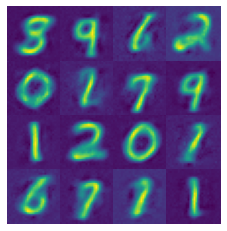

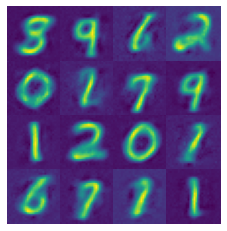

In [23]:
_ = plot(x_recon[:1000], y_train[:1000])

# ANALYSIS

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)#, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
    orig_shape = (-1,) + (x_arr.shape[1:])
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape(orig_shape)
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:max_size]
        x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p], _x_enc[p]
        x_arr = x_arr.reshape(orig_shape)
    
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc

# NOW GENERATE all data points
max_size = min(1000, len(x_train))
x_arrs = []
test_size = len(x_train)
n_ = 0
while n_ < test_size:
    p = np.random.permutation(len(x_test))[:200]
    x_test_sample = x_test[p]
    x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=4, branch_factor=2, max_size=max_size)
    x_arrs.append(x_arr)
    n_ += len(x_arr)
    print("generated {}/{} points".format(n_, test_size), _x_enc.shape, x_arr.shape)

x_gens = np.concatenate(x_arrs, axis=0)[:len(x_train)]

# COMPUTE GROMOV-WASSERSTEIN
gw = gromorov_wasserstein_d(x_train, x_gens)

# COMPUTE BILIP CONSTANT
Ks = bilip(_x_enc, x_arr, 100)
print('Mean bi-Lipschitz constant: {:.4f} +- {:.4f}'.format(np.mean(Ks), np.std(Ks)))
print('Gromov-wasserstein distance: {:.4f}'.format(gw))

In [ ]:
# pick subset size
n_p = min(1000, len(x_train))
p = np.random.permutation(len(x_train))[:n_p]
x_train_p = x_train[p]
y_train_p = y_train[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train_p, normalize_cov=False)
g = plot(x_gen, y_train_p, x2=x_train_p, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]

### RANDOM WALK TESTING

In [ ]:
p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=10)

In [ ]:
p = np.random.permutation(len(x_arr))
x_true_n_gen = np.concatenate([x_test_sample, x_arr[p]], axis=0)
g = plot(x_true_n_gen, shuffle=False)

In [ ]:
g, ax = plot(x_arr, x2=x_test, label1='predicted', label2='true', alpha2=0.2)
plt.title('predicted vs true points in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test)[1], label1='predicted', label2='true')
plt.title('predicted vs true points in latent space')

In [ ]:
g = plot(x_arr, x2=x_test_sample, label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test_sample)[1], label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in latent space')